In [1]:
import sys
sys.path.append('../')
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)


In [2]:
pot_NFW = potential.NFWPotential(m=1e12,r_s=20.0,units=usys)

In [3]:
ts = jnp.linspace(0,3000,1500)
w0=jnp.array([20.,0.,20.,.0,.2,.0])
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=True )



In [4]:
hamiltonian_field = fields.hamiltonian_field(pot_NFW)
hamiltonian_field.term(0.0,jnp.array([1.,2.,3.,.2,.3,.4]), None)

Array([ 0.2       ,  0.3       ,  0.4       , -0.0011937 , -0.00238739,
       -0.00358109], dtype=float64)

In [5]:
kwargs = {'rtol':1e-6,'atol':1e-6,}


In [6]:
field_orb = fields.integrate_field(w0=w0, ts=ts,field=hamiltonian_field, backwards_int=False)
sol = pot_NFW.integrate_orbit(w0=w0, ts=ts,dense=False , **kwargs)


sol2 = pot_NFW.integrate_orbit(w0=w0+.01, ts=ts,dense=False , **kwargs)


In [7]:
field_orb.ys

Array([[ 2.00000000e+01,  0.00000000e+00,  2.00000000e+01,
         0.00000000e+00,  2.00000000e-01,  0.00000000e+00],
       [ 1.99976463e+01,  4.00251143e-01,  1.99976463e+01,
        -2.35209985e-03,  1.99976463e-01, -2.35209985e-03],
       [ 1.99905856e+01,  8.00408074e-01,  1.99905856e+01,
        -4.70379790e-03,  1.99905852e-01, -4.70379790e-03],
       ...,
       [ 1.56611034e+01, -1.47372295e+01,  1.56611034e+01,
         9.66737618e-02,  1.64439007e-01,  9.66737618e-02],
       [ 1.58525121e+01, -1.44062086e+01,  1.58525121e+01,
         9.46042403e-02,  1.66352894e-01,  9.46042403e-02],
       [ 1.60397604e+01, -1.40714069e+01,  1.60397604e+01,
         9.25163046e-02,  1.68217294e-01,  9.25163046e-02]],      dtype=float64)

In [8]:
sol.ys.sum()

Array(-1419.79805427, dtype=float64)

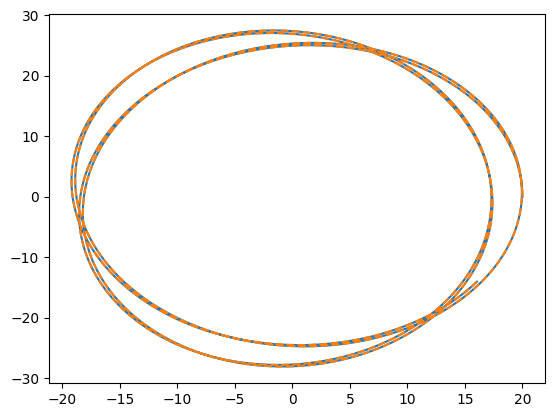

In [9]:
plt.plot(field_orb.ys[:,0], field_orb.ys[:,1])
plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

In [10]:
kwargs = {'rtol':1e-8}


ts.shape

(1500,)

In [11]:
l, t = pot_NFW.gen_stream_scan(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493,kval_arr=1.0) 

In [12]:
#lv, tv = pot_NFW.gen_stream_vmapped(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, **kwargs)

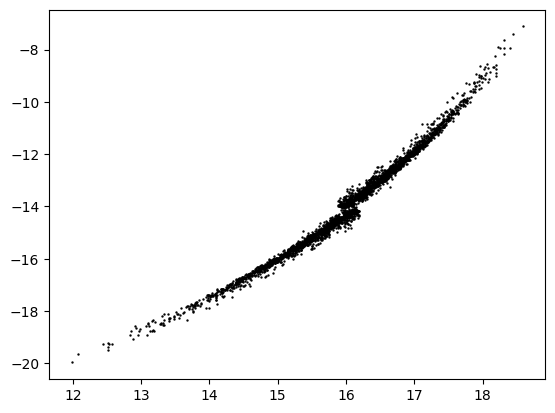

In [13]:
plt.scatter(l[:,0], l[:,1],s=0.5,color='k')
plt.scatter(t[:,0], t[:,1],s=0.5,color='k')

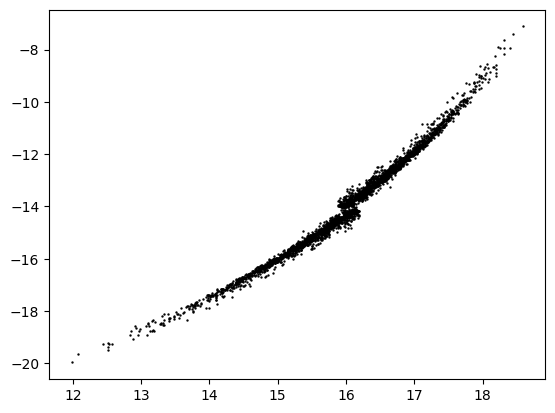

In [14]:
plt.scatter(l[:,0], l[:,1],s=0.5,color='k')
plt.scatter(t[:,0], t[:,1],s=0.5,color='k')

#plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

#plt.scatter(lv[:,0], lv[:,1],s=0.5,color='r')
#plt.scatter(tv[:,0], tv[:,1],s=0.5,color='r')

In [15]:
kwargs = {'rtol':1e-5, 'atol':1e-5}

In [16]:
diffrax.Tsit5(scan_kind="bounded")

Tsit5(scan_kind='bounded')

In [17]:
ld_td = pot_NFW.gen_stream_scan_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493, solver=diffrax.Bosh3(scan_kind="bounded"))

In [18]:
ld_td

Solution(
  t0=f64[1499,2],
  t1=f64[1499,2],
  ts=None,
  ys=None,
  interpolation=DenseInterpolation(
    ts=f64[1499,2,10001],
    ts_size=weak_i64[1499,2],
    infos={
      'k':
      f64[1499,2,10000,4,6],
      'y0':
      f64[1499,2,10000,6],
      'y1':
      f64[1499,2,10000,6]
    },
    interpolation_cls=<bound method ThirdOrderHermitePolynomialInterpolation.from_k of <class 'diffrax._local_interpolation.ThirdOrderHermitePolynomialInterpolation'>>,
    direction=weak_i64[1499,2],
    t0_if_trivial=f64[1499,2],
    y0_if_trivial=f64[1499,2,6]
  ),
  stats={
    'max_steps':
    weak_i64[1499,2],
    'num_accepted_steps':
    weak_i64[1499,2],
    'num_rejected_steps':
    weak_i64[1499,2],
    'num_steps':
    weak_i64[1499,2]
  },
  result=EnumerationItem(
    _value=i32[1499,2],
    _enumeration=<class 'diffrax._solution.RESULTS'>
  ),
  solver_state=None,
  controller_state=None,
  made_jump=None,
  event_mask=None
)

In [19]:
import equinox as eqx
ind = 22
arr, narr = eqx.partition(ld_td, eqx.is_array)
arr = jax.tree_util.tree_map(lambda x: x[ind,0], arr)
interp = eqx.combine(arr, narr)

eval_func_lead = interp.evaluate
eval_func_lead(2800.0)

Array([-11.5755588 , -18.69334719, -11.6163844 ,   0.12739725,
        -0.13871488,   0.12742963], dtype=float64)

In [25]:
StreamSculptor.eval_dense_stream_id(time=2200.0, interp_func=ld_td, idx=28, lead=True)

Array([ 11.58439133, -20.5431288 ,  11.61594373,   0.10767265,
         0.15159345,   0.1078196 ], dtype=float64)

In [19]:
ld, td = StreamSculptor.eval_dense_stream(2200.0, ld_td)

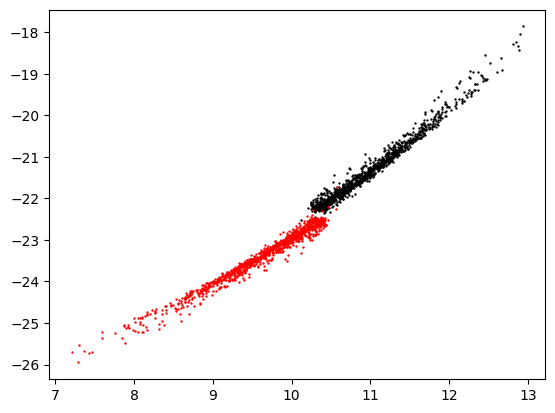

In [20]:
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='r')


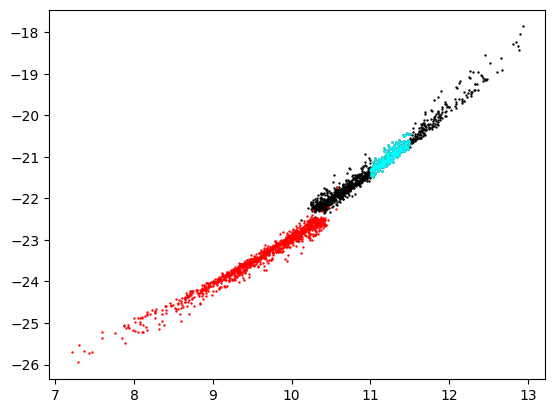

In [21]:
in_bool = (ld[:,0]>11) & (ld[:,0]<11.5)
plt.scatter(ld[:,0], ld[:,1],s=0.5,color='k')
plt.scatter(td[:,0], td[:,1],s=0.5,color='r')

plt.scatter(ld[in_bool,0], ld[in_bool,1],s=0.5,color='cyan')

x0v0_SH = jnp.mean(ld[in_bool,:],axis=0)

In [22]:
x0v0_SH.shape

(6,)

In [23]:
#ldv_tdv = pot_NFW.gen_stream_vmapped_dense(prog_w0=w0,ts=ts,Msat=1e4,seed_num=493,solver=diffrax.Bosh3(scan_kind='bounded'), **kwargs)

In [24]:
#ldv, tdv = StreamSculptor.eval_dense_stream(500.0, ldv_tdv)


In [25]:
#plt.scatter(ldv[:,0], ldv[:,1],s=0.5,color='k')
#plt.scatter(tdv[:,0], tdv[:,1],s=0.5,color='k')


In [26]:
from perturbative import GenerateMassRadiusPerturbation, BaseStreamModel

In [27]:
## Subhalo potential
np.random.seed(3022)
N = 10
M = jnp.zeros(N)
M = M.at[0].set(1.0)
a = jnp.ones(N)*.2
subhalo_x0 = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))

subhalo_x0 = subhalo_x0.at[0].set(x0v0_SH[:3])
subhalo_v = jnp.array(np.random.normal(loc=0,scale=1,size=(N,3)))
subhalo_v = subhalo_v.at[0].set(x0v0_SH[3:] + jnp.array([0.05,0.001,.0]))

np.random.seed(30222)
subhalo_t0 = jnp.array(np.random.normal(loc=0,scale=1,size=(N,)))*0.0 #jnp.ones(N)*0.0
subhalo_t0 = subhalo_t0.at[0].set(2200.0)
t_window = jnp.ones(N)*250.0

pot_SH = potential.SubhaloLinePotential(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)
pot_structural = potential.SubhaloLinePotential_dRadius(m=M, a=a, subhalo_x0=subhalo_x0,
subhalo_v=subhalo_v, subhalo_t0=subhalo_t0, t_window=t_window,units=usys)

pot_structural.potential(jnp.array([1.,2,3.]),0.0)


Array(0., dtype=float64)

In [28]:
pot_SH.potential_per_SH(jnp.array([2,3,4.]),2200.0)

Array([-1.68381906e-13,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00], dtype=float64)

In [29]:
base_model = BaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=ts, Msat=1e4,seednum=493, 
solver=diffrax.Dopri5(scan_kind='bounded'), dtmin=0.5, dtmax=None, dense=True )

/opt/anaconda3/envs/streamsculptor_env/lib/python3.13/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/streamsculptor_env/lib/python3.13/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/streamsculptor_env/lib/python3.13/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/opt/anaconda3/envs/streamsculptor_env/lib/python3.13/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eva

In [31]:
StreamSculptor.eval_dense_stream(3000.0, base_model.stream_interp)

(Array([[ 16.85261972, -12.30470978,  16.87017387,   0.08133746,
           0.17677056,   0.08177825],
        [ 17.73451425,  -9.94150381,  17.81585444,   0.06755605,
           0.18514156,   0.06743699],
        [ 18.19870324,  -8.74442425,  18.13698247,   0.06041894,
           0.18831629,   0.0605955 ],
        ...,
        [ 15.88920931, -13.97532634,  15.98518875,   0.09233183,
           0.16780498,   0.09220201],
        [ 15.92685397, -13.9949712 ,  15.97326857,   0.09142327,
           0.16683713,   0.09225564],
        [ 15.94010874, -13.9736974 ,  15.91144886,   0.09152674,
           0.16611642,   0.09156169]], dtype=float64),
 Array([[ 15.11150159, -15.74790845,  15.10318756,   0.10321597,
           0.15846629,   0.10275861],
        [ 13.78401045, -17.79109184,  13.70253404,   0.11516667,
           0.14482453,   0.1150448 ],
        [ 12.97140171, -18.76347036,  13.03673937,   0.12057873,
           0.1374044 ,   0.12064413],
        ...,
        [ 16.19038383, -14.167

In [33]:
base_model.stream_interp

Solution(
  t0=f64[1499,2],
  t1=f64[1499,2],
  ts=None,
  ys=None,
  interpolation=DenseInterpolation(
    ts=f64[1499,2,10001],
    ts_size=weak_i64[1499,2],
    infos={
      'k':
      f64[1499,2,10000,7,6],
      'y0':
      f64[1499,2,10000,6],
      'y1':
      f64[1499,2,10000,6]
    },
    interpolation_cls=<class 'diffrax._solver.dopri5._Dopri5Interpolation'>,
    direction=weak_i64[1499,2],
    t0_if_trivial=f64[1499,2],
    y0_if_trivial=f64[1499,2,6]
  ),
  stats={
    'max_steps':
    weak_i64[1499,2],
    'num_accepted_steps':
    weak_i64[1499,2],
    'num_rejected_steps':
    weak_i64[1499,2],
    'num_steps':
    weak_i64[1499,2]
  },
  result=EnumerationItem(
    _value=i32[1499,2],
    _enumeration=<class 'diffrax._solution.RESULTS'>
  ),
  solver_state=None,
  controller_state=None,
  made_jump=None,
  event_mask=None
)

In [32]:
pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = base_model.streamICs

jnp.hstack([pos_close_arr, vel_close_arr]).shape

(1500, 6)

In [94]:
pert_Gen = GenerateMassRadiusPerturbation(potential_base=pot_NFW,potential_perturbation=pot_SH,
potential_structural=pot_structural, units=usys,BaseStreamModel=base_model,solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9, atol=1e-9,dtmin=0.01,dtmax=None)#,dtmin=0.01,dtmax=2.0)

In [95]:
pot_NFW.gradient(jnp.array([101.,22,4.]),2500.0)

Array([4.03089106e-04, 8.78015874e-05, 1.59639250e-05], dtype=float64)

In [96]:
out = pert_Gen.compute_perturbation_ICs()

In [97]:
sol.ys[-1]

Array([ 16.03975613, -14.07138239,  16.03975613,   0.09251608,
         0.16821761,   0.09251608], dtype=float64)

In [98]:
pert_Gen.prog_base.ys[0].shape

(1500, 6)

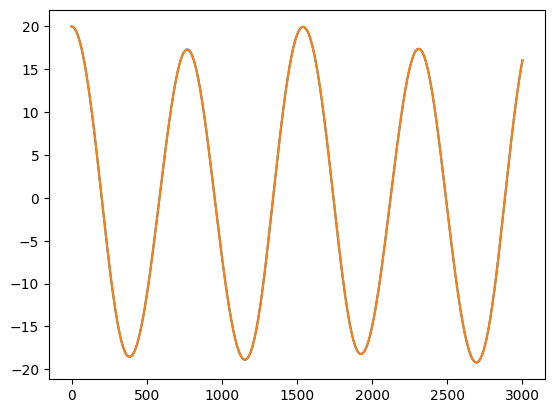

In [99]:
plt.plot(sol.ts,sol.ys[:,0])
plt.plot(pert_Gen.prog_base.ts,pert_Gen.prog_base.ys[0][:,0])

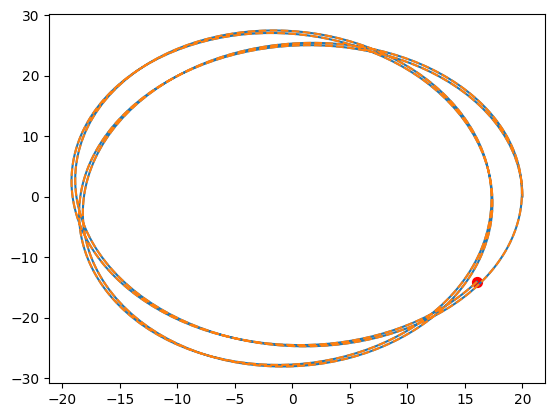

In [100]:
plt.plot(pert_Gen.prog_base.ys[0][:,0],pert_Gen.prog_base.ys[0][:,1])
plt.scatter(sol.ys[-1][0],sol.ys[-1][1],color='r',s=50)
#plt.plot(field_orb.ys[:,0], field_orb.ys[:,1])
plt.plot(sol.ys[:,0], sol.ys[:,1],ls='--')

In [101]:
pert_Gen.prog_fieldICs.shape

(1500, 10, 12)

In [102]:
pert_Gen.gradientPotentialStructural_per_SH(jnp.array([1,2,.3]), 2300.0)

Array([[ 1.30714238e-18, -4.08865925e-19,  1.09323313e-18],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float64)

In [103]:
fc = pert_Gen.base_stream.prog_loc_fwd[-1]#ts[-126]

In [104]:
lead_out_and_derivs, trail_out_and_derivs = pert_Gen.compute_perturbation_OTF(cpu=True, 
solver=diffrax.Dopri8(scan_kind='bounded'),rtol=1e-9,atol=1e-9,dtmin=0.01,dtmax=None)

In [105]:
trail_out_and_derivs[0]

Array([[ 15.11145856, -15.74799038,  15.10314474,   0.10321643,
          0.15846578,   0.10275907],
       [ 13.78396969, -17.79115678,  13.70249329,   0.11516702,
          0.14482404,   0.11504515],
       [ 12.97135488, -18.76353746,  13.03669254,   0.12057909,
          0.13740384,   0.12064449],
       ...,
       [ 16.19034539, -14.16744194,  16.09436324,   0.09270077,
          0.16862986,   0.0928297 ],
       [ 16.15270007, -14.1477974 ,  16.106285  ,   0.0936091 ,
          0.16959765,   0.0927765 ],
       [ 16.13944508, -14.16907151,  16.16810506,   0.09350549,
          0.17031834,   0.09347063]], dtype=float64)

In [106]:
lead_out_and_derivs[0]

Array([[ 16.8525868 , -12.3048028 ,  16.87014074,   0.08133798,
          0.17677015,   0.08177877],
       [ 17.73449221,  -9.94158545,  17.81583248,   0.06755651,
          0.18514129,   0.06743744],
       [ 18.19868212,  -8.74451672,  18.13696125,   0.06041945,
          0.18831602,   0.06059602],
       ...,
       [ 15.88917142, -13.97541558,  15.98515086,   0.09233232,
          0.16780451,   0.0922025 ],
       [ 15.92681603, -13.99506045,  15.97323063,   0.09142376,
          0.16683666,   0.09225613],
       [ 15.94007088, -13.97378648,  15.911411  ,   0.09152722,
          0.16611595,   0.09156218]], dtype=float64)

In [107]:
#lead_out_and_derivs_v, trail_out_and_derivs_v = pert_Gen.compute_perturbation_OTF(cpu=False)

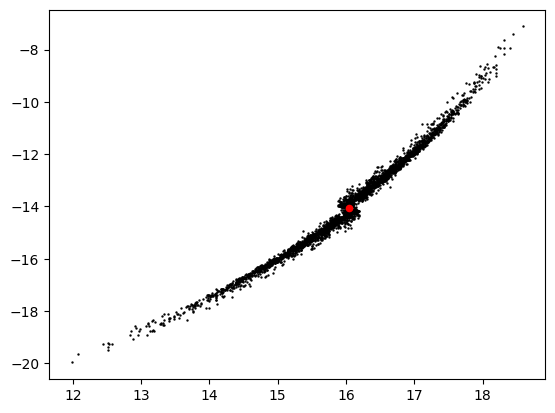

In [108]:
plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(fc[0],fc[1],color='r',s=20)

#plt.scatter(l[:,0], l[:,1],s=0.5,color='g')
#plt.scatter(t[:,0], t[:,1],s=0.5,color='g')
#plt.scatter(lead_out_and_derivs_v[0][:,0], lead_out_and_derivs_v[0][:,1],s=0.5,color='r')
#plt.scatter(trail_out_and_derivs_v[0][:,0], trail_out_and_derivs_v[0][:,1],s=0.5,color='r')

In [109]:
lead_out_and_derivs[1].shape

(1499, 10, 12)

In [110]:
lead_out_and_derivs[0].shape

(1499, 6)

(-21.0, -7.0)

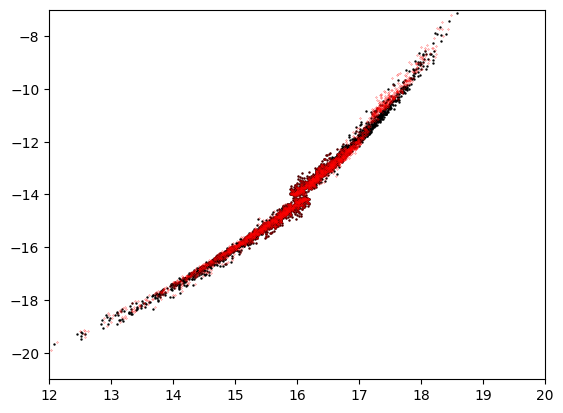

In [111]:

M_sh = 2e6
lead_lin = lead_out_and_derivs[0] + lead_out_and_derivs[1][:,0,:6]*M_sh
trail_lin = trail_out_and_derivs[0] + trail_out_and_derivs[1][:,0,:6]*M_sh
stream_lin = jnp.vstack([lead_lin,trail_lin])
#######

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')
#plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.xlim(12,20)
plt.ylim(-21,-7)

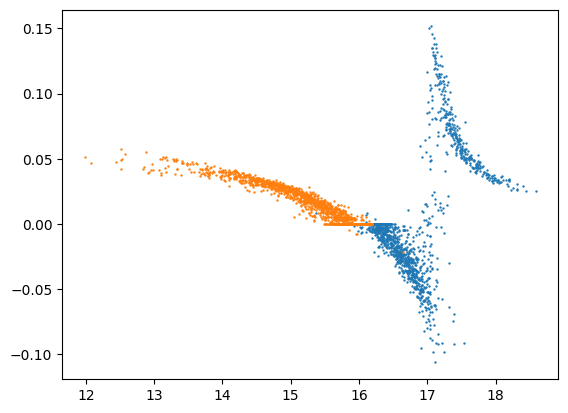

In [112]:
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,0]*M_sh,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,0]*M_sh,s=.5)

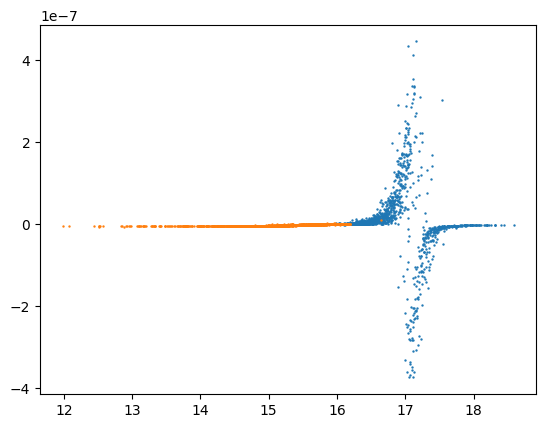

In [113]:
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,6]*1,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,6]*1,s=.5)

In [114]:
import warnings

# Ignore all warnings
#warnings.simplefilter('ignore')

# Ignore only DeprecationWarnings
#warnings.simplefilter('ignore', category=DeprecationWarning)

# Treat FutureWarnings as errors
#warnings.simplefilter('ignore', category=FutureWarning)

In [115]:
def gen_at_mass(mass):
    pot_SH_single = potential.SubhaloLinePotential(m=jnp.array([mass]), a=jnp.array([a[0]]), subhalo_x0=jnp.array([subhalo_x0[0,:]]),
    subhalo_v=jnp.array([subhalo_v[0,:]]), subhalo_t0=jnp.array([subhalo_t0[0]]), t_window=t_window[0],units=usys)

    prog_wf = pot_NFW.integrate_orbit(w0=w0, ts=jnp.array([ts[0],ts[-1]]), solver=diffrax.Dopri8(scan_kind='bounded')).ys[1]
    pot_lst = [pot_NFW, pot_SH_single]
    pot_total = potential.Potential_Combine(potential_list=pot_lst, units=usys)
    prog_init = pot_total.integrate_orbit(w0=prog_wf, t0=ts.max(),t1=ts.min(), ts=jnp.array([ts.min()])).ys[0]


    lead_nonlin, trail_nonlin = StreamSculptor.gen_stream_vmapped_with_pert(pot_base=pot_NFW,pot_pert=pot_SH_single, 
    ts=ts, prog_w0=prog_init, Msat=1e4, seed_num=493, solver=diffrax.Dopri8(scan_kind='bounded'), rtol=1e-9, atol=1e-9,dtmin=0.01, jump_ts=pert_Gen.jump_ts)
    return lead_nonlin, trail_nonlin

l_non, t_non = jax.jacfwd(gen_at_mass)(0.0)


In [116]:
lead_nonlin, trail_nonlin = gen_at_mass(2e6)
stream_nonlin = jnp.vstack([lead_nonlin,trail_nonlin])

In [117]:
lead_unpert, trail_unpert = gen_at_mass(0.0)

In [118]:

M_sh = 2e6
lead_lin_ = lead_out_and_derivs[0] + l_non*M_sh
trail_lin_ = trail_out_and_derivs[0] + t_non*M_sh
stream_lin_ = jnp.vstack([lead_lin_,trail_lin_])

(-21.0, -7.0)

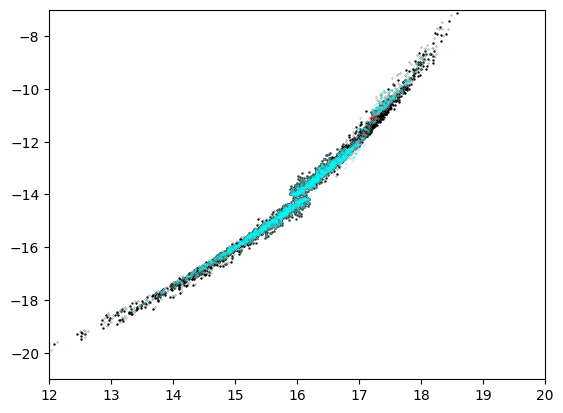

In [119]:

M_sh = 2e6
lead_lin = lead_out_and_derivs[0] + lead_out_and_derivs[1][:,0,:6]*M_sh
trail_lin = trail_out_and_derivs[0] + trail_out_and_derivs[1][:,0,:6]*M_sh
stream_lin = jnp.vstack([lead_lin,trail_lin])
#######

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')

plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')
plt.scatter(stream_lin_[:,0], stream_lin_[:,1],s=0.05,color='cyan')

#plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.xlim(12,20)
plt.ylim(-21,-7)

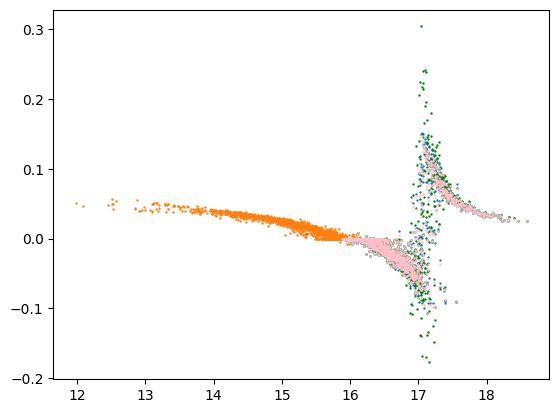

In [123]:
dim = 0
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,dim]*M_sh,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,dim]*M_sh,s=.5)


plt.scatter(lead_out_and_derivs[0][:,0],  l_non[:,dim]*M_sh,s=.5,color='g')

delta_nonlin = lead_nonlin - lead_unpert

plt.scatter(lead_out_and_derivs[0][:,0],  delta_nonlin[:,dim],s=.5,color='pink')


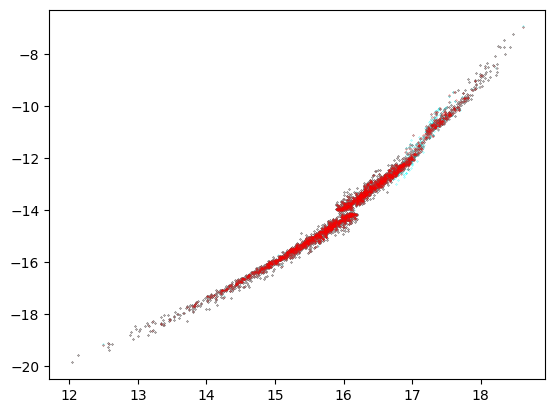

In [124]:
plt.scatter(stream_lin_[:,0], stream_lin_[:,1],s=0.05,color='cyan')
plt.scatter(stream_nonlin[:,0], stream_nonlin[:,1],s=0.05,color='teal')
plt.scatter(stream_lin[:,0], stream_lin[:,1],s=0.05,color='r')


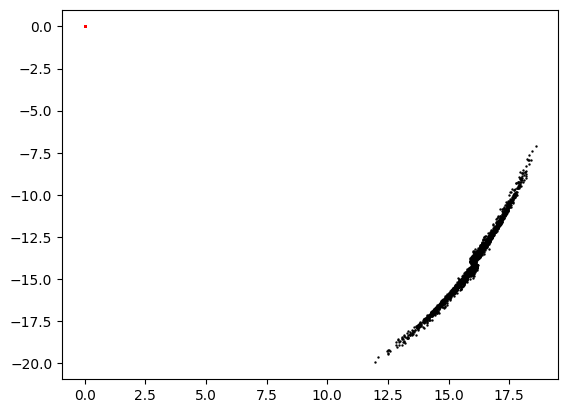

In [127]:

plt.scatter(lead_out_and_derivs[0][:,0], lead_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(trail_out_and_derivs[0][:,0], trail_out_and_derivs[0][:,1],s=0.5,color='k')
plt.scatter(l_non[:,0], l_non[:,1],s=0.5,color='r')
plt.scatter(t_non[:,0], t_non[:,1],s=0.5,color='r')

In [128]:
a[0]

Array(0.2, dtype=float64)

In [129]:
def gen_at_mass_radius(mass, radius):
    pot_SH_single = potential.SubhaloLinePotential(m=jnp.array([mass]), a=jnp.array([radius]), subhalo_x0=jnp.array([subhalo_x0[0,:]]),
    subhalo_v=jnp.array([subhalo_v[0,:]]), subhalo_t0=jnp.array([subhalo_t0[0]]), t_window=t_window[0],units=usys)
    prog_wf = pot_NFW.integrate_orbit(w0=w0, ts=jnp.array([ts[0],ts[-1]]), solver=diffrax.Dopri8(scan_kind='bounded')).ys[1]
    pot_lst = [pot_NFW, pot_SH_single]
    pot_total = potential.Potential_Combine(potential_list=pot_lst, units=usys)
    prog_init = pot_total.integrate_orbit(w0=prog_wf, t0=ts.max(),t1=ts.min(), ts=jnp.array([ts.min()])).ys[0]


    lead_nonlin, trail_nonlin = StreamSculptor.gen_stream_vmapped_with_pert(pot_base=pot_NFW,pot_pert=pot_SH_single, 
    ts=ts, prog_w0=prog_init, Msat=1e4, seed_num=493, solver=diffrax.Dopri8(scan_kind='bounded'), rtol=1e-9, atol=1e-9,dtmin=0.01, jump_ts=pert_Gen.jump_ts)
    return lead_nonlin, trail_nonlin
dlead_dmass, dtrail_dmass = jax.jacfwd(gen_at_mass_radius,argnums=(0,))(0.0,0.2)
d2lead, d2trail = jax.jacfwd(jax.jacfwd(gen_at_mass_radius,argnums=(0,)),argnums=(1,))(0.0,0.2)

dlead_dmass, dtrail_dmass = dlead_dmass[0], dtrail_dmass[0]
d2lead, d2trail = d2lead[0][0], d2trail[0][0]


(-1e-06, 1e-06)

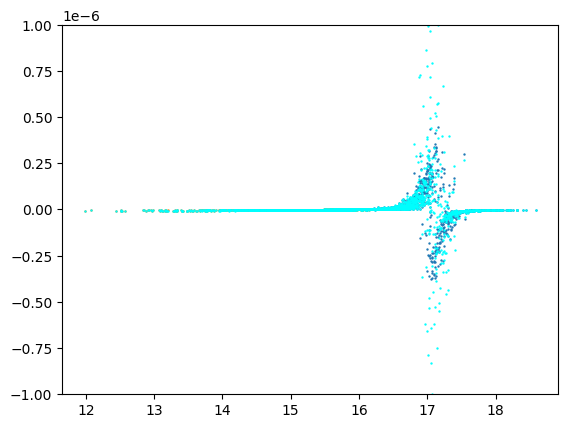

In [138]:
dd=0
plt.scatter(lead_out_and_derivs[0][:,0],  lead_out_and_derivs[1][:,0,6+dd]*1,s=.5)
plt.scatter(trail_out_and_derivs[0][:,0],  trail_out_and_derivs[1][:,0,6+dd]*1,s=.5)


plt.scatter(lead_out_and_derivs[0][:,0],  d2lead[:,dd]*1,s=.5,color='cyan')
plt.scatter(trail_out_and_derivs[0][:,0],  d2trail[:,dd]*1,s=.5,color='cyan')
plt.ylim(-1e-6,1e-6)


In [138]:
prog_init = pot_total.integrate_orbit(w0=prog_wf, t0=ts.max(),t1=ts.min(), ts=jnp.array([ts.min()])).ys[0]


In [139]:
prog_init

Array([ 1.99980532e+01, -2.56099519e-01,  1.99843423e+01,  1.41873880e-03,
        1.99946222e-01,  1.36733644e-03], dtype=float64)

In [28]:
stream_lin.shape

(2998, 6)

In [31]:
lead_out_and_derivs[1]/lead_out_and_derivs_v[1]




Array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [28]:
output[0].ys[0].shape#.ys[1].shape

(1499, 2, 6)

In [35]:
output[0].ys[1].shape

(1499, 2, 10, 12)

In [20]:
pert_Gen.compute_perturbation_ICs()[1].shape

(1500, 10, 12)

In [38]:
pert_Gen.perturbation_ICs[1].shape

(1500, 10, 12)

In [31]:
base_model.streamICs[3].shape

(1500, 3)

In [33]:
 jnp.hstack([base_model.streamICs[0], base_model.streamICs[2]]).shape

(1500, 6)

In [22]:
lout, tout = pert_Gen.compute_base_stream(cpu=False)


In [29]:
base_model.dRel_dIC.shape

(1500, 2, 6, 6)

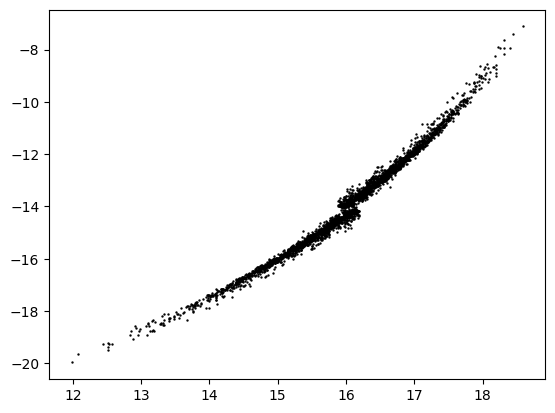

In [23]:
plt.scatter(lout[:,0], lout[:,1],s=0.5,color='k')
plt.scatter(tout[:,0], tout[:,1],s=0.5,color='k')


In [19]:
pert_Gen.fieldICs.ys[1]

(1500, 10, 12)

In [20]:
ts.shape

(1500,)

In [30]:
jnp.sum(pert_Gen.fieldICs.ys[1],axis=1)[2]

Array([-1.35768480e-13,  4.49920989e-15, -1.35768149e-13, -3.87432793e-14,
        1.29758755e-15, -3.87550906e-14,  5.01245915e-16, -1.72591489e-17,
        4.99398722e-16,  1.42980983e-16, -4.97669531e-18,  1.42482560e-16],      dtype=float64)

In [31]:
pert_Gen.jump_ts

Array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float64)

In [ ]:
pot_SH.subhalo_x0.shape

(10, 3)

In [ ]:
pert_Gen.prog_w0

AttributeError: 'GenerateMassRadiusPerturbation' object has no attribute 'prog_w0'

In [ ]:
pert_field = fields.MassRadiusPerturbation_OTF(pert_Gen)



In [ ]:
example_coords = [jnp.hstack([jnp.ones(3),jnp.ones(3)]), 
                jnp.hstack([jnp.ones((10,3)),jnp.ones((10,3)), jnp.ones((10,3)), jnp.ones((10,3))])]
#example_coords[1].shape
pert_field.term(0.0,example_coords, None)

[Array([ 1.        ,  1.        ,  1.        , -0.00290453, -0.00290453,
        -0.00290453], dtype=float64),
 Array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774549e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774548e-04, 3.09774549e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774548e-04,
         3.09774548e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.09774549e-04,
         3.09774548e-04, 3.09774548e-04, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.09774549e-04, 3.09774549e-04, 3.09774549e-04],
        [

In [ ]:
jnp.ones((10,3))

Array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float64)

In [ ]:
pert_Gen.gradientPotentialPerturbation_per_SH(jnp.array([1.,20.,3.]),0.0).shape

(10, 3)

In [ ]:
obj = BaseStreamModel(potential_base=pot_NFW,prog_w0=w0, ts=ts, Msat=1e4,seednum=493, solver=diffrax.Dopri5(scan_kind='bounded') )

In [ ]:
obj.prog_loc_fwd.shape

(1500, 6)

In [ ]:
obj.dRel_dIC

Array([[[[ 9.96418614e-01,  4.87120170e-04, -4.42824880e-05,
          -9.30743752e-02,  1.31131449e-01, -2.19712970e-02],
         [ 1.03703439e-03,  9.96216989e-01,  1.02067057e-04,
           4.18392106e-02,  8.93746158e-02, -1.20250323e-01],
         [ 1.34265400e-03,  8.89893678e-04,  9.96105638e-01,
          -6.74033188e-02,  7.26106414e-02,  3.69975941e-03],
         [ 6.32656012e-06, -4.10394642e-07, -7.62879260e-07,
           1.00013673e+00, -4.93138630e-04,  2.95917439e-04],
         [ 3.56197289e-06, -1.90869969e-06, -3.86061491e-06,
           5.61375084e-04,  1.00018700e+00, -7.25433287e-04],
         [ 2.54819675e-06, -2.46533325e-06, -3.85776049e-06,
          -6.29240028e-04,  3.29080427e-04,  1.00034053e+00]],

        [[ 1.00358139e+00, -4.87120170e-04,  4.42824880e-05,
           9.30743752e-02, -1.31131449e-01,  2.19712970e-02],
         [-1.03703439e-03,  1.00378301e+00, -1.02067057e-04,
          -4.18392106e-02, -8.93746158e-02,  1.20250323e-01],
         [-1.3

In [ ]:
deriv = obj.release_func_jacobian()

In [ ]:
deriv.shape

(1500, 2, 6, 6)

In [ ]:
from genstream import StreamModel
